In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model,initializers, regularizers, activations, constraints
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,Average, Layer
import numpy as np
import math
import sys
import os
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
from plyfile import *
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d 
import numpy as np
import scipy.stats
import random
import pandas as pd
from sklearn.metrics import confusion_matrix

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#点云文件导入
##############导入点云数据#################
pcd_AC13_1 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC13-1.ply")
pcd_AC13_2 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC13-2.ply")
pcd_AC16_3 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC16-3.ply")
pcd_AC16_4 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC16-4.ply")
pcd_UT5_1  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-1.ply")
pcd_UT5_2  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-2.ply")
pcd_UT5_3  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-3.ply")
pcd_UT5_4  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-4.ply")
pcd_SMA13_1= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/SMA13-1.ply")
pcd_SMA13_2= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/SMA13-2.ply")
pcd_OGFC10_1= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/OGFC10-1.ply")
#############点云标准化####################
def standard_pointcloud(point_cloud):
    Point_standard=[]
    Point=np.asarray(point_cloud.points)    
    x=np.array(Point[:,0])[...,np.newaxis]
    y=np.array(Point[:,1])[...,np.newaxis]
    z=np.array(Point[:,2])[...,np.newaxis]
    Point_standard=np.concatenate((x-np.min(x),y-np.min(y),z-np.min(z)),axis=-1)
    return Point_standard

AC13_1=standard_pointcloud(pcd_AC13_1)
AC13_2=standard_pointcloud(pcd_AC13_2)
AC16_3=standard_pointcloud(pcd_AC16_3)
AC16_4=standard_pointcloud(pcd_AC16_4)
UT5_1=standard_pointcloud(pcd_UT5_1)
UT5_2=standard_pointcloud(pcd_UT5_2)
UT5_3=standard_pointcloud(pcd_UT5_3)
UT5_4=standard_pointcloud(pcd_UT5_4)
SMA13_1= standard_pointcloud(pcd_SMA13_1)
SMA13_2= standard_pointcloud(pcd_SMA13_2)
OGFC10_1 =  standard_pointcloud(pcd_OGFC10_1)

point_cloud_array_group = []
point_cloud_array_group.append(AC13_1)
point_cloud_array_group.append(AC13_2)
point_cloud_array_group.append(AC16_3)
point_cloud_array_group.append(AC16_4)
point_cloud_array_group.append(UT5_1)
point_cloud_array_group.append(UT5_2)
point_cloud_array_group.append(UT5_3)
point_cloud_array_group.append(UT5_4)
point_cloud_array_group.append(SMA13_1)
point_cloud_array_group.append(SMA13_2)
point_cloud_array_group.append(OGFC10_1)
#############点云标准化####################
def standard_pointcloud(point_cloud):
    Point_standard=[]  
    x=np.array(point_cloud[:,0])[...,np.newaxis]
    y=np.array(point_cloud[:,1])[...,np.newaxis]
    z=np.array(point_cloud[:,2])[...,np.newaxis]
    Point_standard=np.concatenate((x-np.min(x),y-np.min(y),z-np.min(z)),axis=-1)
    return Point_standard
######################按照计算的H_final进行窗口滑动切分#########################
H_final=51
AC13=[0,6,4,3.5,5.5,7.5,10.5,16,23.5,18.5,5,0]#级配
AC16=[0,5.4,2.4,2.4,3.7,4.1,7.8,5.5,26.3,20.1,16.6,5.7]#级配 
SMA13=[0,10.7,2.1,1.4,1.1,1.2,2.9,9.4,30.3,31.5,8.2,1.2]#级配
UT5=[0,6.7,2,2.5,5,20,13.4,48.8,1.5,0.1,0,0]#级配
OGFC10=[0,4,1.5,2,2,2.5,4,44,35,5,0,0]#级配
def split_slide(point_cloud_array_origion,H_new=H_final, intervial =[5,5]):
    L=int(np.max(point_cloud_array_origion[:,0]))
    W=int(np.max(point_cloud_array_origion[:,1]))
    Point_cloud_small = []
    L_intervial = intervial[0]
    W_intervial = intervial[1]
    for i in range (0,L-H_new,L_intervial):
        for j in range (0,W-H_new,W_intervial):
            temp_point_cloud = point_cloud_array_origion[np.where((point_cloud_array_origion[:,1]>i)&
                                                                  (point_cloud_array_origion[:,1]<(H_new+i))&
                                                                  (point_cloud_array_origion[:,0]>j)&
                                                                  (point_cloud_array_origion[:,0]<(H_new+j)))]
            temp_point_cloud = standard_pointcloud(temp_point_cloud)
            Point_cloud_small.append(temp_point_cloud)
    return Point_cloud_small
####################原始图像拆分子点云集########################################
PointCloud_new =[]
#制作Ground truth
Y_Data=np.zeros((1,12))
for i in range(11):
    temp=split_slide(point_cloud_array_group[i])
    #print(len(temp))
    PointCloud_new=np.concatenate((PointCloud_new,temp),axis=0)
    if (i==0) or (i==1):
        temp2 = np.full((len(temp),12),AC13)
    elif (i==2) or (i==3):
        temp2 = np.full((len(temp),12),AC16)
    elif (i==4) or (i==5) or (i==6) or (i==7):
        temp2 = np.full((len(temp),12),UT5)
    elif (i==8) or (i==9):
        temp2 = np.full((len(temp),12),SMA13)
    elif (i==10):
        temp2 = np.full((len(temp),12),OGFC10) 
    #print(temp2.shape)
    Y_Data = np.concatenate((Y_Data,temp2),axis=0)
    #print(np.array(Y_Data).shape)
Y_Data = np.delete(Y_Data, 1, 0)#把第一行0删掉
print(Y_Data.shape)
#print(len(PointCloud_new))
#计算最小子点云点数
num_min=PointCloud_new[0].shape[0]
for i in range(len(PointCloud_new)):
    num_point = PointCloud_new[i].shape[0]
    if num_min>num_point:
        num_min = num_point
#print(num_min)
#根据最小点云数进行降采样，根据设置的点数降采样
def pointCloud_downsampling(Point_cloud_array, num_pointCloud=30000):
    # estimate radius for rolling ball
    pcd=o3d.geometry.PointCloud()
    pcd.points=o3d.utility.Vector3dVector(Point_cloud_array)
    pcd.estimate_normals()
    # estimate radius for rolling ball
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 1.5 * avg_dist   
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))
    pcd_new = o3d.geometry.TriangleMesh.sample_points_uniformly(mesh, number_of_points=num_pointCloud) # 采样点云
    #o3d.visualization.draw_geometries([pcd_new],width=1024, height=1024)
    New_Point_cloud_array = np.asarray(pcd_new.points)
    return New_Point_cloud_array

PointCloud_Standard =[]
for i in range(len(PointCloud_new)):
    PointCloud_Standard.append(pointCloud_downsampling(PointCloud_new[i],6000))
print(np.array(PointCloud_Standard).shape)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(1579, 12)
(1579, 6000, 3)


In [42]:
#### 数据集1579分，切分为1379训练 200测试#######################
arr = np.array(range(0, 1579, 1))
r = np.random.permutation(arr)
Train_X_Data = []
Train_Y_Data = []
for i in range(1400):
    Train_X_Data.append(PointCloud_Standard[r[i]])
    Train_Y_Data.append(Y_Data[r[i]])

Test_X_Data = []
Test_Y_Data = []
for i in range(1400,1579):
    Test_X_Data.append(PointCloud_Standard[r[i]])
    Test_Y_Data.append(Y_Data[r[i]])
    
Train_X_Data = np.array(Train_X_Data)
Train_Y_Data = np.array(Train_Y_Data)
Test_X_Data = np.array(Test_X_Data)
Test_Y_Data = np.array(Test_Y_Data)

print(Train_X_Data.shape)
print(Train_Y_Data.shape)
print(Test_X_Data.shape)
print(Test_Y_Data.shape)


(1400, 6000, 3)
(1400, 12)
(179, 6000, 3)
(179, 12)


In [4]:
class CustomConvolution(keras.layers.Layer):
    def __init__(self, filters=64, kernel_size=(1, 1), strides=(1, 1), padding='VALID', bn_momentum=0.99,
                 activation=None, apply_bn=False):
        super(CustomConvolution, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.bn_momentum = bn_momentum
        self.activation = activation
        self.convolution = keras.layers.Conv2D(filters, kernel_size, strides, padding)
        self.apply_bn = apply_bn
        if self.apply_bn:
            self.bn = keras.layers.BatchNormalization(momentum=bn_momentum)

    def call(self, inputs, training=None):
        x = self.convolution(inputs)
        if self.apply_bn:
            x = self.bn(x, training=training)
        if self.activation:
            x = self.activation(x)
        return x

    def get_config(self):
        config = super(CustomConvolution, self).get_config()
        config.update(
            {
                'filters': self.filters,
                'kernel_size': self.kernel_size,
                'strides': self.strides,
                'padding': self.padding,
                'bn_momentum': self.bn_momentum,
                'activation': self.activation,
                'apply_bn': self.apply_bn
            }
        )
    @classmethod
    def from_config(cls, config):
        return cls(**config)

class CustomDense(keras.layers.Layer):
    def __init__(self, units=256, activation=tf.nn.relu, bn_momentum=0.99, apply_bn=False):
        super(CustomDense, self).__init__()
        self.filters = units
        self.bn_momentum = bn_momentum
        self.activation = activation
        self.dense = keras.layers.Dense(units)
        self.apply_bn = apply_bn
        if self.apply_bn:
            self.bn = keras.layers.BatchNormalization(momentum=bn_momentum)

    def call(self, inputs, training=None):
        x = self.dense(inputs)
        if self.apply_bn:
            x = self.bn(x, training=training)
        if self.activation:
            x = self.activation(x)
        return x

    def get_config(self):
        config = super(CustomDense, self).get_config()
        config.update(
            {
                'units': self.units,
                'activation': self.activation,
                'bn_momentum': self.bn_momentum,
                'apply_bn': self.apply_bn
            }
        )

    @classmethod
    def from_config(cls, config):
        return cls(**config)
class input_TransformNet(keras.layers.Layer):
    def __init__(self, add_regularization=False, bn_momentum=0.99,dim=3, name=None, **kwargs):
        super(input_TransformNet, self).__init__(name=name, **kwargs)
        self.add_regularization = add_regularization
        self.bn_momentum = bn_momentum
        self.dim=dim
        self.conv0 = CustomConvolution(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='VALID',
                                       bn_momentum=bn_momentum, activation=tf.nn.relu,apply_bn=True)
        self.conv1 = CustomConvolution(filters=128, kernel_size=(1, 1), strides=(1, 1), padding='VALID',
                                       bn_momentum=self.bn_momentum,apply_bn=True)
        self.conv2 = CustomConvolution(filters=1024, kernel_size=(1, 1), strides=(1, 1), padding='VALID',
                                       bn_momentum=self.bn_momentum,apply_bn=True)
        self.dense0 = CustomDense(units=512, activation=tf.nn.relu, bn_momentum=self.bn_momentum,apply_bn=True)
        self.dense1 = CustomDense(units=256, activation=tf.nn.relu, bn_momentum=self.bn_momentum,apply_bn=True)

    def build(self, input_shape):
        self.K = self.dim
        self.w = self.add_weight(name='w', shape=[256, self.K ** 2], initializer=tf.zeros_initializer, dtype=tf.float32)
        self.b = self.add_weight(name='b', shape=(self.K, self.K), initializer=tf.zeros_initializer, dtype=tf.float32)
        I = tf.constant(np.eye(self.K), dtype=tf.float32)
        self.b = tf.math.add(self.b, I)

    def call(self, inputs, training=None):
        x = inputs  # BxNxkxdim
        x = self.conv0(x, training=training)  # BxNxkx64
        #print(x.get_shape())
        x = self.conv1(x, training=training)  # BxNxkx128
        #print(x.get_shape())
        x = tf.compat.v1.reduce_max(x, axis=-2, keep_dims=True)  # BxNx1x128
        #print(x.get_shape())
        x = self.conv2(x, training=training)  # BxNx1x1024
        #print(x.get_shape())
        x = tf.squeeze(x, axis=2)  # BxNx1024
        #print(x.get_shape())
        x = tf.reduce_max(x, axis=1)  # Bx1024
        #print(x.get_shape())
        x = self.dense0(x, training=training)  # Bx512
        x = self.dense1(x, training=training)  # Bx256

        x = tf.expand_dims(x, axis=1)  # Bx1x256
        x = tf.matmul(x, self.w)  # Bx1xK**2
        x = tf.squeeze(x, axis=1)  # BxK**2
        x = tf.reshape(x, (-1, self.K, self.K))  # BxKxK
        x += self.b
        #print(x.get_shape())

        if self.add_regularization:
            eye = tf.constant(np.eye(self.K), dtype=tf.float32)
            x_transpose = tf.transpose(x, perm=[0, 2, 1])
            x_xt = tf.matmul(x, x_transpose)
            reg = tf.nn.l2_loss(eye - x_xt)
            self.add_loss(1e-3 * reg)

        return x

    def get_config(self):
        config = super(TransformNet, self).get_config()
        config.update(
            {
                'add_regularization': self.add_regularization,
                'bn_momentum': self.bn_momentum,
            }
        )

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [27]:
def pairwise_distance(point_cloud):
    """Compute pairwise distance of a point cloud.
    Args:
    point_cloud: tensor (batch_size, num_points, num_dims)
    Returns:
    pairwise distance: (batch_size, num_points, num_points)
    """
    og_batch_size = point_cloud.get_shape().as_list()[0]
    point_cloud = tf.squeeze(point_cloud)
    if og_batch_size == 1:
        point_cloud = tf.expand_dims(point_cloud, 0)
    point_cloud_transpose = tf.transpose(point_cloud, perm=[0, 2, 1])
    #print(point_cloud_transpose.get_shape())
    point_cloud_inner = tf.matmul(point_cloud, point_cloud_transpose)
    point_cloud_inner = -2*point_cloud_inner
    point_cloud_square = tf.compat.v1.reduce_sum(tf.square(point_cloud), axis=-1, keep_dims=True)
    point_cloud_square_tranpose = tf.transpose(point_cloud_square, perm=[0, 2, 1])
    return point_cloud_square + point_cloud_inner + point_cloud_square_tranpose

def knn(adj_matrix, k=20):
    """Get KNN based on the pairwise distance.
    Args:
    pairwise distance: (batch_size, num_points, num_points)
    k: int
    Returns:
    nearest neighbors: (batch_size, num_points, k)
    """
    neg_adj = -adj_matrix
    _, nn_idx = tf.nn.top_k(neg_adj, k=k)
    return nn_idx

def get_edge_feature(point_cloud, nn_idx, k=20):
    """Construct edge feature for each point
    Args:
    point_cloud: (batch_size, num_points, 1, num_dims)
    nn_idx: (batch_size, num_points, k)
    k: int
    Returns:
    edge features: (batch_size, num_points, k, num_dims)
    """
    og_batch_size = point_cloud.get_shape().as_list()[0]
    point_cloud = tf.squeeze(point_cloud)
    if og_batch_size == 1:
        point_cloud = tf.expand_dims(point_cloud, 0)

    point_cloud_central = point_cloud

    point_cloud_shape = point_cloud.get_shape()
    batch_size = point_cloud_shape[0]
    num_points = point_cloud_shape[1]
    num_dims = point_cloud_shape[2]

    idx_ = tf.range(batch_size) * num_points
    idx_ = tf.reshape(idx_, [batch_size, 1, 1]) 

    point_cloud_flat = tf.reshape(point_cloud, [-1, num_dims])
    point_cloud_neighbors = tf.gather(point_cloud_flat, nn_idx+idx_)
    point_cloud_central = tf.expand_dims(point_cloud_central, axis=-2)

    point_cloud_central = tf.tile(point_cloud_central, [1, 1, k, 1])

    edge_feature = tf.concat([point_cloud_central, point_cloud_neighbors-point_cloud_central], axis=-1)
    return edge_feature
    
    
def get_model(point_cloud,n_classes, bn_momentum):
    """ Classification PointNet, input is BxNx3, output Bx40 """
    batch_size = point_cloud.get_shape()[0]
    num_point =  point_cloud.get_shape()[1]
    feature=point_cloud.get_shape()[2]
    k = 20
    add_regularization = True

    adj_matrix = pairwise_distance(point_cloud)
    #print(adj_matrix.get_shape())
    nn_idx = knn(adj_matrix, k=k)
    #print(nn_idx.get_shape())
    edge_feature = get_edge_feature(point_cloud, nn_idx=nn_idx, k=k)
    #print(edge_feature.get_shape())
    
    input_transform = input_TransformNet(add_regularization=add_regularization, 
                                         bn_momentum=bn_momentum,
                                         name='input_transformation',dim=feature)(edge_feature)# BxNx3 --> Bx3x3
    
    point_cloud_transform = tf.matmul(point_cloud, input_transform)#BxNx3
    
    adj_matrix = pairwise_distance(point_cloud_transform)
    nn_idx = knn(adj_matrix, k=k)
    edge_feature = get_edge_feature(point_cloud_transform, nn_idx=nn_idx, k=k)
    
    net = CustomConvolution(filters=64, kernel_size=(1, 1), 
                            strides=(1, 1), padding='VALID',
                            bn_momentum=bn_momentum, 
                            activation=tf.nn.relu,apply_bn=True)(edge_feature)  # BxNx1x64

    net = tf.compat.v1.reduce_max(net, axis=-2, keep_dims=True)
    net1 = net

    adj_matrix = pairwise_distance(net)
    nn_idx = knn(adj_matrix, k=k)
    edge_feature = get_edge_feature(net, nn_idx=nn_idx, k=k)

    net = CustomConvolution(filters=64, kernel_size=(1, 1), 
                            strides=(1, 1), padding='VALID',
                            bn_momentum=bn_momentum, 
                            activation=tf.nn.relu,apply_bn=True)(edge_feature)  # BxNx1x64
    
    net = tf.compat.v1.reduce_max(net, axis=-2, keep_dims=True)
    net2 = net

    adj_matrix = pairwise_distance(net)
    nn_idx = knn(adj_matrix, k=k)
    edge_feature = get_edge_feature(net, nn_idx=nn_idx, k=k)

    net = CustomConvolution(filters=64, kernel_size=(1, 1), 
                            strides=(1, 1), padding='VALID',
                            bn_momentum=bn_momentum, 
                            activation=tf.nn.relu,apply_bn=True)(edge_feature)  # BxNx1x64
    
    net = tf.compat.v1.reduce_max(net, axis=-2, keep_dims=True)
    net3 = net

    adj_matrix = pairwise_distance(net)
    nn_idx = knn(adj_matrix, k=k)
    edge_feature = get_edge_feature(net, nn_idx=nn_idx, k=k)

    net = CustomConvolution(filters=128, kernel_size=(1, 1), 
                            strides=(1, 1), padding='VALID',
                            bn_momentum=bn_momentum, 
                            activation=tf.nn.relu,apply_bn=True)(edge_feature)  # BxNx1x128
    
    net = tf.compat.v1.reduce_max(net, axis=-2, keep_dims=True)
    net4 = net
    
    net = CustomConvolution(filters=1024, kernel_size=(1, 1), 
                            strides=(1, 1), padding='VALID',
                            bn_momentum=bn_momentum, 
                            activation=tf.nn.relu,apply_bn=True)(tf.concat([net1, net2, net3, net4], axis=-1))  # BxNx1x1024

    net = tf.compat.v1.reduce_max(net, axis=1, keep_dims=True)

    # MLP on global point cloud vector
    net = tf.reshape(net, [batch_size, -1])
    net = CustomDense(units=512, activation=tf.nn.relu, bn_momentum=bn_momentum,apply_bn=True)(net)
    net = keras.layers.Dropout(0.5)(net)
    net = CustomDense(units=256, activation=tf.nn.relu, bn_momentum=bn_momentum,apply_bn=True)(net)
    net = keras.layers.Dropout(0.5)(net)
    output_layer = CustomDense(units=n_classes, activation=tf.nn.softmax, bn_momentum=bn_momentum,apply_bn=True)(net)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [28]:
class DGCNN_cls(tf.keras.Model):
    def __init__(self, k=20, output_channels = 12):
        super(DGCNN_cls, self).__init__()
        self.k=k
        self.layer1 = input_TransformNet(add_regularization=True, 
                                         bn_momentum=0.99,
                                         name='input_transformation',dim=3)
        self.layer2 = CustomConvolution(filters=64, kernel_size=(1, 1), 
                                        strides=(1, 1), padding='VALID',
                                        bn_momentum=0.99, activation=tf.nn.relu,apply_bn=True)
        self.layer3 = CustomConvolution(filters=64, kernel_size=(1, 1), 
                                        strides=(1, 1), padding='VALID',
                                        bn_momentum=0.99, activation=tf.nn.relu,apply_bn=True)
        self.layer4 = CustomConvolution(filters=64, kernel_size=(1, 1), 
                                        strides=(1, 1), padding='VALID',
                                        bn_momentum=0.99, activation=tf.nn.relu,apply_bn=True)
        self.layer5 = CustomConvolution(filters=128, kernel_size=(1, 1), 
                                        strides=(1, 1), padding='VALID',
                                        bn_momentum=0.99, activation=tf.nn.relu,apply_bn=True)
        self.layer6 = CustomConvolution(filters=1024, kernel_size=(1, 1), 
                                        strides=(1, 1), padding='VALID',
                                        bn_momentum=0.99, activation=tf.nn.relu,apply_bn=True)
        self.layer7=CustomDense(units=512, activation=tf.nn.relu, bn_momentum=0.99,apply_bn=True)
        self.layer8=keras.layers.Dropout(0.5)
        self.layer9=CustomDense(units=256, activation=tf.nn.relu, bn_momentum=0.99,apply_bn=True)
        self.layer10=keras.layers.Dropout(0.5)
        self.layer11 = keras.layers.Flatten()
        self.layer12=keras.layers.Dense(units=output_channels, activation=tf.nn.relu)
    
    def call(self,inputs):
        batch_size    = inputs.get_shape()[0]
        #print(batch_size)
        #print(inputs.get_shape())
        adj_matrix1   = pairwise_distance(inputs)
        nn_idx1       = knn(adj_matrix1, k=self.k)
        edge_feature1 = get_edge_feature(inputs, nn_idx=nn_idx1, k=self.k)
        #print(edge_feature1)
        input_transform = self.layer1(edge_feature1)
        #print(input_transform.shape)
        point_cloud_transform = tf.matmul(inputs, input_transform)#BxNx3
        #print(point_cloud_transform)
        adj_matrix2 = pairwise_distance(point_cloud_transform)
        #print(adj_matrix2)
        nn_idx2 = knn(adj_matrix2, k=self.k)
        #print(nn_idx2)
        edge_feature2 = get_edge_feature(point_cloud_transform, nn_idx=nn_idx2, k=self.k)
        
        net = self.layer2(edge_feature2)
        net = tf.compat.v1.reduce_max(net, axis=-2, keep_dims=True)
        net1 = net
        
        adj_matrix3 = pairwise_distance(net)
        #print(adj_matrix3 )
        nn_idx3 = knn(adj_matrix3, k=self.k)
        edge_feature3 = get_edge_feature(net, nn_idx=nn_idx3, k=self.k)

        net = self.layer3(edge_feature3 )  # BxNx1x64
        net = tf.compat.v1.reduce_max(net, axis=-2, keep_dims=True)
        net2 = net
        
        adj_matrix4 = pairwise_distance(net)
        nn_idx4 = knn(adj_matrix4, k=self.k)
        edge_feature4 = get_edge_feature(net, nn_idx=nn_idx4, k=self.k)
        
        net = self.layer4(edge_feature4)  # BxNx1x64
        net = tf.compat.v1.reduce_max(net, axis=-2, keep_dims=True)
        net3 = net
        
        adj_matrix5 = pairwise_distance(net)
        nn_idx5 = knn(adj_matrix5, k=self.k)
        edge_feature5 = get_edge_feature(net, nn_idx=nn_idx5, k=self.k)
        
        net = self.layer5(edge_feature5)  # BxNx1x128
        net = tf.compat.v1.reduce_max(net, axis=-2, keep_dims=True)
        net4 = net
        
        net = self.layer6(tf.concat([net1, net2, net3, net4], axis=-1))  # BxNx1x1024
        net = tf.compat.v1.reduce_max(net, axis=1, keep_dims=True)

        # MLP on global point cloud vector
        net = tf.reshape(net, [batch_size, -1])
        net = self.layer7(net)
        net = self.layer8(net)
        net = self.layer9(net)
        net = self.layer10(net)
        net = self.layer11(net)
        output_layer = self.layer12(net)
        #print(output_layer.shape)

        return output_layer

In [35]:
Batch_size=8
DGCNN = DGCNN_cls()
#inputs = tf.random.uniform((10, 1024, 3))
#output = DCGNN(inputs)
DGCNN.build(input_shape=(8, 6000, 3))
#DGCNN.summary()
lr=1e-3
DGCNN.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.MAE)
Callback = keras.callbacks.ModelCheckpoint("DGCNN.h5", 
                                           monitor='val_loss', 
                                           save_best_only=True, 
                                           save_weights_only=True)
Model_history=DGCNN.fit(x=Train_X_Data,y=Train_Y_Data,batch_size=Batch_size,epochs =200,callbacks=Callback,validation_split=0.2)

Epoch 1/200
140/140 [==============================] - 51s 348ms/step - loss: 6.7463 - val_loss: 7.9438
Epoch 2/200
140/140 [==============================] - 48s 346ms/step - loss: 4.2116 - val_loss: 5.7413
Epoch 3/200
140/140 [==============================] - 49s 348ms/step - loss: 3.5686 - val_loss: 7.0664
Epoch 4/200
140/140 [==============================] - 49s 348ms/step - loss: 3.5026 - val_loss: 11.5078
Epoch 5/200
140/140 [==============================] - 49s 349ms/step - loss: 3.3263 - val_loss: 6.8419
Epoch 6/200
140/140 [==============================] - 49s 349ms/step - loss: 2.8241 - val_loss: 5.1410
Epoch 7/200
140/140 [==============================] - 49s 349ms/step - loss: 2.6034 - val_loss: 17.8296
Epoch 8/200
140/140 [==============================] - 49s 349ms/step - loss: 2.7393 - val_loss: 4.7671
Epoch 9/200
140/140 [==============================] - 49s 349ms/step - loss: 2.6682 - val_loss: 5.3498
Epoch 10/200
140/140 [==============================] - 49s 34

140/140 [==============================] - 49s 350ms/step - loss: 1.3781 - val_loss: 2.9573
Epoch 80/200
140/140 [==============================] - 49s 350ms/step - loss: 1.4969 - val_loss: 39.5475
Epoch 81/200
140/140 [==============================] - 49s 350ms/step - loss: 1.5499 - val_loss: 2.2110
Epoch 82/200
140/140 [==============================] - 49s 350ms/step - loss: 1.5007 - val_loss: 5.9430
Epoch 83/200
140/140 [==============================] - 49s 350ms/step - loss: 1.4589 - val_loss: 1.1163
Epoch 84/200
140/140 [==============================] - 49s 351ms/step - loss: 1.4931 - val_loss: 3.1023
Epoch 85/200
140/140 [==============================] - 49s 350ms/step - loss: 1.3033 - val_loss: 3.3800
Epoch 86/200
140/140 [==============================] - 49s 350ms/step - loss: 1.5534 - val_loss: 2.9536
Epoch 87/200
140/140 [==============================] - 49s 350ms/step - loss: 1.5236 - val_loss: 4.9962
Epoch 88/200
140/140 [==============================] - 49s 350ms/s

140/140 [==============================] - 49s 350ms/step - loss: 1.2381 - val_loss: 1.7423
Epoch 157/200
140/140 [==============================] - 49s 350ms/step - loss: 1.2024 - val_loss: 3.9903
Epoch 158/200
140/140 [==============================] - 49s 350ms/step - loss: 1.2787 - val_loss: 1.5916
Epoch 159/200
140/140 [==============================] - 49s 350ms/step - loss: 1.2204 - val_loss: 2.9604
Epoch 160/200
140/140 [==============================] - 49s 350ms/step - loss: 1.3490 - val_loss: 0.7396
Epoch 161/200
140/140 [==============================] - 49s 350ms/step - loss: 1.2002 - val_loss: 1.1413
Epoch 162/200
140/140 [==============================] - 49s 350ms/step - loss: 1.1551 - val_loss: 0.9076
Epoch 163/200
140/140 [==============================] - 49s 350ms/step - loss: 1.3254 - val_loss: 5.8469
Epoch 164/200
140/140 [==============================] - 49s 350ms/step - loss: 1.3082 - val_loss: 3.6505
Epoch 165/200
140/140 [==============================] - 49s

In [36]:
Save_history = Model_history.history
Save_history = pd.DataFrame(Save_history)
writer = pd.ExcelWriter('C:/Users/Administrator/Desktop/surface/实验结果存放/DGCNN_loss.xlsx')  #关键2，创建名称为hhh的excel表格
Save_history.to_excel(writer,'page_1',float_format='%.5f')  #关键3，float_format 控制精度，将data_df写到hhh表格的第一页中。若多个文件，可以在page_2中写入
writer.save() 

179/179 [==============================] - 5s 27ms/step - loss: 8.0206


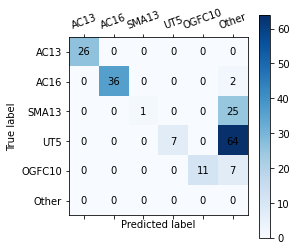

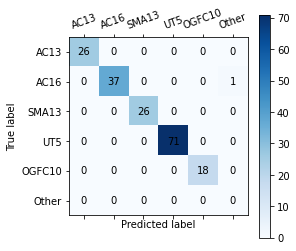

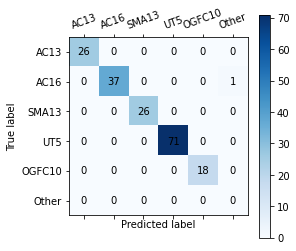

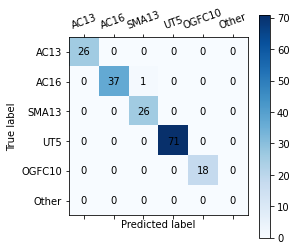

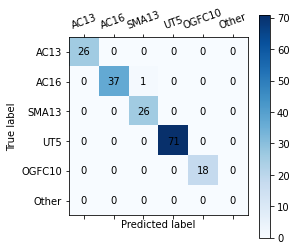

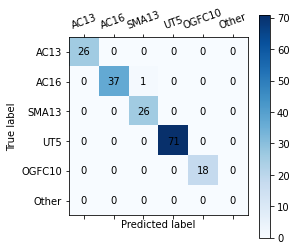

In [43]:
############Test性能测试###################
def identification(predicted_gradient,real_gradient,threshold):
    AC13=[0,6,4,3.5,5.5,7.5,10.5,16,23.5,18.5,5,0]#级配
    AC16=[0,5.4,2.4,2.4,3.7,4.1,7.8,5.5,26.3,20.1,16.6,5.7]#级配 
    SMA13=[0,10.7,2.1,1.4,1.1,1.2,2.9,9.4,30.3,31.5,8.2,1.2]#级配
    UT5=[0,6.7,2,2.5,5,20,13.4,48.8,1.5,0.1,0,0]#级配
    OGFC10=[0,4,1.5,2,2,2.5,4,44,35,5,0,0]#级配
    if np.average(np.abs(real_gradient-AC13))==0:
        Real_result=0
    elif np.average(np.abs(real_gradient-AC16))==0:
        Real_result=1
    elif np.average(np.abs(real_gradient-SMA13))==0:
        Real_result=2
    elif np.average(np.abs(real_gradient-UT5))==0:
        Real_result=3
    elif np.average(np.abs(real_gradient-OGFC10))==0:
        Real_result=4
        
    R_AC13=np.average(np.abs(predicted_gradient-AC13))
    R_AC16=np.average(np.abs(predicted_gradient-AC16))
    R_SMA13=np.average(np.abs(predicted_gradient-SMA13))
    R_UT5=np.average(np.abs(predicted_gradient-UT5))
    R_OGFC10=np.average(np.abs(predicted_gradient-OGFC10))
    
    Predicted_result =np.argmin(np.array([R_AC13,R_AC16,R_SMA13,R_UT5,R_OGFC10]))
    
    if np.min(np.array([R_AC13,R_AC16,R_SMA13,R_UT5,R_OGFC10]))>threshold:
        Predicted_result = 5
    
    return Real_result, Predicted_result

n_classes = 12
Batch_size=1
DGCNN = DGCNN_cls()
DGCNN.build(input_shape=(Batch_size, 6000, 3))
DGCNN.compile(optimizer=keras.optimizers.Adam(lr), loss=tf.keras.losses.MAE)
DGCNN.evaluate(Test_X_Data,Test_Y_Data,batch_size=Batch_size)
DGCNN.load_weights("DGCNN.h5")
Thr_list = [0.5,1,1.5,2,2.5,3]
for Thr in Thr_list:
    Real_result = []
    Predicted_result = []
    for i in range(len(Test_X_Data)):
        R,P=identification(DGCNN(np.array(Test_X_Data[i])[np.newaxis,...])[0],Test_Y_Data[i],Thr)
        Real_result.append(R)
        Predicted_result.append(P)
    #######绘制混淆矩阵################
    C = confusion_matrix(Real_result, Predicted_result, labels=[0,1,2,3,4,5]) 
    plt.matshow(C, cmap=plt.cm.Blues) # 根据最下面的图按自己需求更改颜色
    plt.colorbar()
    for i in range(len(C)):
        for j in range(len(C)):
            plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(range(0,6), labels=['AC13','AC16','SMA13','UT5','OGFC10','Other'], rotation=20) # 将x轴或y轴坐标，刻度 替换为文字/字符
    plt.yticks(range(0,6), labels=['AC13','AC16','SMA13','UT5','OGFC10','Other'])
    plt.savefig('C:/Users/Administrator/Desktop/surface/实验结果存放/DGCNN'+ str(Thr) +'.png',dpi=600)#保存图片
    plt.show()